# DoorDash Delivery Data Exploration
## Binyoh Langhe Theodore

## Investigation Overview


In this investigation, I'm most interested in finding out which features are most useful for predicting, or that might affect delivery duration i.e., the time taken between an order being made (created_at) and when the order is actually delivered (actual_delivery_time).


## Dataset Overview

This dataset contains a subset of deliveries received at DoorDash in 2015 in a subset of the cities. The dataset is available on [Stratascratch](https://platform.stratascratch.com/data-projects/delivery-duration-prediction). Each row in this dataset corresponds to one unique delivery, and each column corresponds to a feature as explained below. There are **197428** orders/deliveries and **16** features in the original dataset, though I've engineered a few more features that I believe would aid me in my analysis.

**Note**: All money (dollar) values given in the data are in cents and all time duration values given are in seconds.


### Data Dictionary
#### Time Features
- market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id.
- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash.
- actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer.

#### Store Features
- store_id: an id representing the restaurant the order was submitted for.
- store_primary_category: cuisine category of the restaurant, e.g., italian, asian.
- order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol.

#### Order Features
- total_items: total number of items in the order.
- subtotal: total value of the order submitted (in cents).
- num_distinct_items: number of distinct items included in the order.
- min_item_price: price of the item with the least cost in the order (in cents).
- max_item_price: price of the item with the highest cost in the order (in cents).

## Data Dictionary (cont'd)
#### Market Features
- total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
- total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
- total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

#### Predictions from Machine Learning Models
- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds).
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds).

## Project Goal
The aim of this analytical exploration is to find out what factors affect delivery duration, and hence could be useful in predicting the delivery duration for any order. As such, I intend to answer the following questions:
- What features or variables affect delivery duration?
    - How do they relate to delivery duration and each other?
- Which markets/regions and/or protocols if any have a large proportion of orders with high delivery duration values?
- What can be done to reduce the frequency of orders with high delivery duration values? 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

default_color = sns.color_palette()[0]

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
deliveries = pd.read_csv("./datasets/doordash-deliveries.csv")
deliveries_clean = pd.read_csv("./export/doordash-deliveries-cleaned-v2.csv")
multivariate_df = pd.read_csv("./export/doordash-deliveries-clean-v3.csv")

In [3]:
float_cols = [col for col in deliveries_clean.columns if deliveries_clean[col].dtype == "float64"]

# converting all float columns to in datatype
for col in float_cols:
    deliveries_clean = deliveries_clean.astype({col: "Int64"}, errors="ignore")
    


# converting date data columns to datetime datatype
date_cols = deliveries_clean.columns[1:3].tolist()

deliveries_clean[date_cols] = deliveries_clean[date_cols].apply(pd.to_datetime)



In [4]:
# detailed plot labelling function
def plot_label(title, x_label, y_label, legend=False, legend_title=None, legend_loc=1, anchor=None, x_rot=0):
    """
    adds labels to chart and chart elements
    
    title (str, mandatory): chart title
    x_label (str, mandatory): x-axis title/label
    y_label (str, mandatory): y-axis title/label
    legend (bool, optional): adds legend to chart
    legend_title (str, optional): adds/modifies the plot's legend title
    legend_loc (int/str, optional): sets the location of the plot legend
    anchor (tuple (int, int)): sets the location of the plot legend relative to plot itself
    x_rot (int, optional): rotates tick labels of x-axis by number of specified degrees
    """
    try:
        plt.title(title)
        plt.xlabel(x_label, fontweight="bold")
        plt.ylabel(y_label, fontweight="bold")
        plt.xticks(rotation=x_rot)
        if legend:
            plt.legend(title=legend_title, loc=legend_loc, bbox_to_anchor=anchor)
    except:
        print("Input valid arguments")

In [5]:
# axis labelling function
def axes_label(x_label, y_label="", x_rot=0, x_lim=False, lim_val=None, x_ticks=False, tick_val=None):
    """
    adds/modifies plot axes labels
    x_label (str, mandatory): x-axis title/label
    y_label (str, optional): y-axis title/label
    x_rot (int, optional): rotates tick labels of x-axis by number of specified degrees
    """
    try:
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(rotation=x_rot)
        if x_lim:
            plt.xlim(lim_val)
        if x_ticks:
            plt.xticks(tick_val)
    except:
        return "Input valid arguments"

In [6]:
deliveries_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194727 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     193757 non-null  Int64         
 1   created_at                                    194727 non-null  datetime64[ns]
 2   actual_delivery_time                          194727 non-null  datetime64[ns]
 3   delivery_duration                             194727 non-null  int64         
 4   store_id                                      194727 non-null  int64         
 5   store_primary_category                        190042 non-null  object        
 6   order_protocol                                193749 non-null  Int64         
 7   total_items                                   194727 non-null  int64         
 8   subtotal                                      194727 non-nu

## Distribution of Delivery Duration

It can be observed in the plot below that delivery duration has a long tailed distribution, with most orders having delivery durations under 10000 (10k) seconds. However, when plotted on a log scale, the distribution looks more normal, peaking roughly between 2.2k and 3.1k seconds.

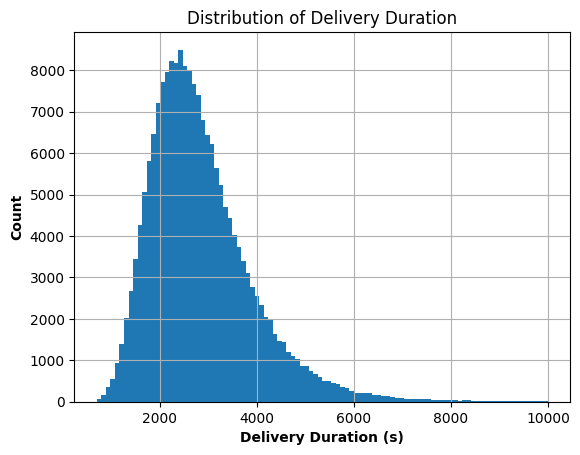

In [7]:
# here we look at the main feature of interest: delivery duration (in seconds)
deliveries_clean['delivery_duration'].hist(bins=100)
plot_label(title="Distribution of Delivery Duration", x_label="Delivery Duration (s)", y_label="Count");

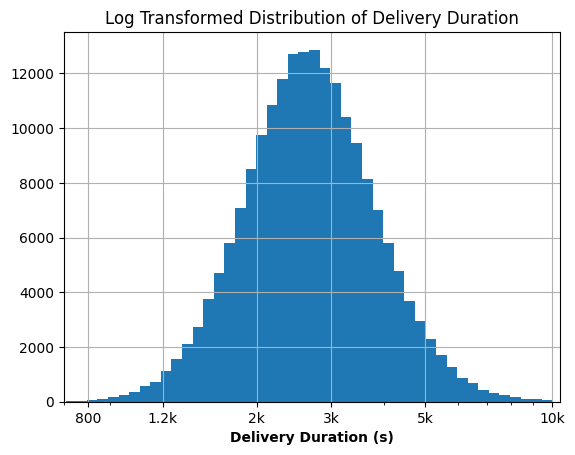

In [8]:
# given the long tail on the original distribution, let's plot it on a log scale
# also let's limit the log scale to remove outlier values
log_binsize = 0.025
bins = 10 ** np.arange(2.3, np.log10(deliveries_clean['delivery_duration'].max())+log_binsize, log_binsize)

deliveries_clean['delivery_duration'].hist(bins=bins)
plot_label(title="Log Transformed Distribution of Delivery Duration", x_label="Delivery Duration (s)", y_label="Count")
axes_label(x_label="Delivery Duration (s)", x_ticks=True, x_lim=True, lim_val=[7e2, 1.04e4])
plt.xscale("log")
plt.xticks([8e2, 1.2e3, 2e3, 3e3, 5e3, 1e4], [800, '1.2k', '2k', '3k', '5k', '10k']);

## Relationship Between Delivery Duration and Primary Predictor Features

Delivery duration, as anticipated, has a higher positive correlation (though weak in all cases) with estimated order creation to delivery duration (0.26), subtotal (0.22), and total outstanding orders within 10 miles of the delivery location (0.19), when compared to the other numerical features, except the estimated store to consumer drive duration (0.24). It is worth noting though, that estimated order creation to delivery duration is a feature generated from estimated store to consumer drive duration, so this correlation is to be expected.

As expected, there is a slightly negative correlation between delivery duration and the ratio of free dashers to onshift dashers within 10 miles of the store (-0.19). This is the only feature that has a negative correlation with delivery duration. This makes sense since the higher the proportion of free dashers compared to that of busy dashers, the more likely orders are to be delivered earlier.

Total outstanding orders might be a given, since there is likely a higher chance that an area with a larger number of orders/deliveries is quite populated and/or busy increasing the likelihood of being stuck in traffic.

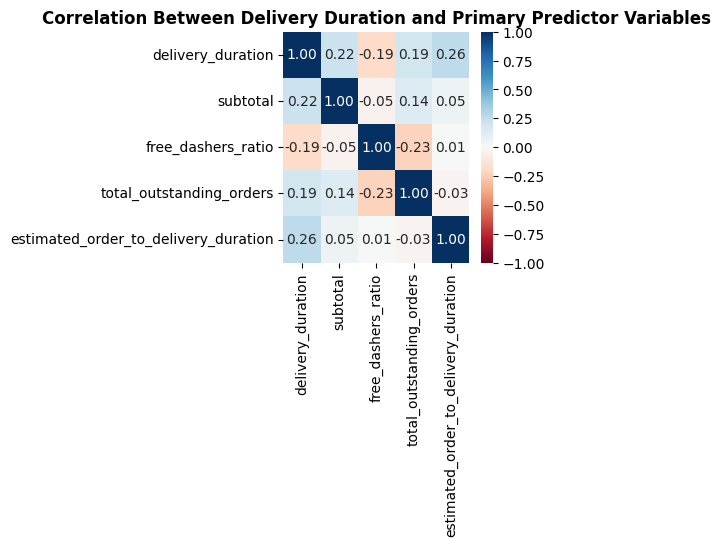

In [9]:
# now we can look at some correlation plots
# starting with the correlation between the primary numerical features of interest
primary_num_cols = ['delivery_duration', 'subtotal', 'free_dashers_ratio', 'total_outstanding_orders', 'estimated_order_to_delivery_duration']

plt.figure(figsize=[3, 3])
sns.heatmap(deliveries_clean[primary_num_cols].corr(), annot=True, cmap="RdBu", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Between Delivery Duration and Primary Predictor Variables", fontweight="bold");

## Delivery Duration by Market
Market 1 appears to have slightly higher delivery duration values compared to the other 5 that have fairly similar values on average.

In [10]:
market_df = deliveries_clean.dropna(subset='market_id').astype({'market_id': "string"})

store_df = deliveries_clean.dropna(subset='store_id').astype({'store_id': "string"})

order_prot_df = deliveries_clean.dropna(subset='order_protocol')

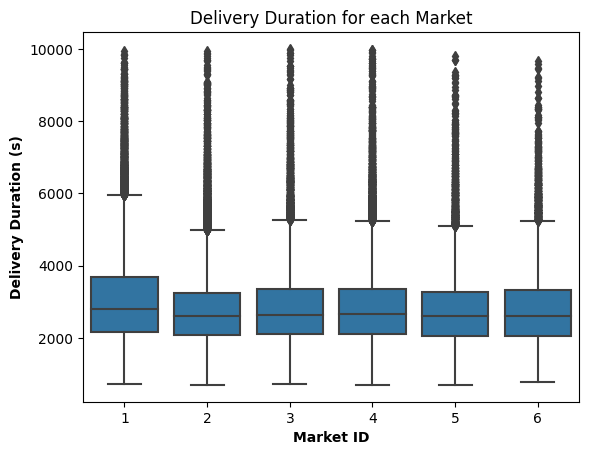

In [11]:
# plotting relationship between delivery duration and market id
sns.boxplot(data=market_df, x='market_id', y='delivery_duration', color=default_color)
plot_label(title="Delivery Duration for each Market", x_label="Market ID", y_label="Delivery Duration (s)");

## Delivery Duration by Order Protocol
Meanwhile protocol 6 orders tend to have highest duration times compared to the other protocols, though protocol 7 orders appear to have the lowest delivery duration times compared to the others.

This is because, in most cases, protocol 6 orders tend to have the highest delivery duration times, as is the case with markets 1, 3, 5, and 6.

However, there are significantly fewer protocol 7 orders (18 total) compared to the others, all but 1 such orders existing only in market 5. As such definite conclusions regarding protocol 7 orders may not be drawn given the extremely small sample pool.

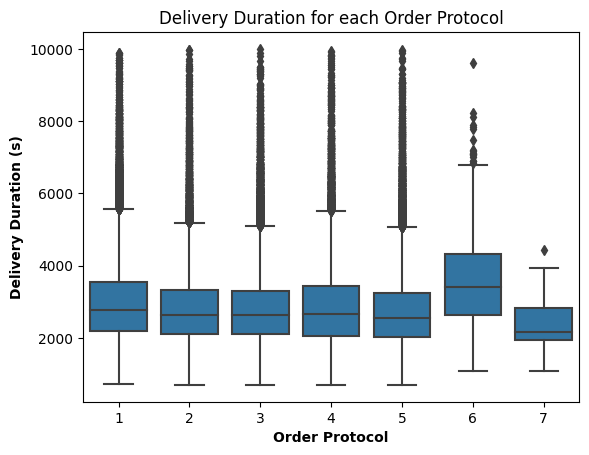

In [12]:
# let's look at the relationship between delivery duration and order protocol
sns.boxplot(data=order_prot_df, x='order_protocol', y='delivery_duration', color=default_color)
plot_label(title="Delivery Duration for each Order Protocol", x_label="Order Protocol", y_label="Delivery Duration (s)");

## Delivery Duration and the Availability of Free Dashers
Irrespective of market or order protocol, delivery duration on average is higher when there are no free dashers available.

Given that delivery duration is usually lower when free dashers are available further strengthens my assertion that delivery duration for an order is likely affected by the availability of free dashers, and by extension, the proportion of free dashers to the total number of onshift dashers within 10 miles of the store.

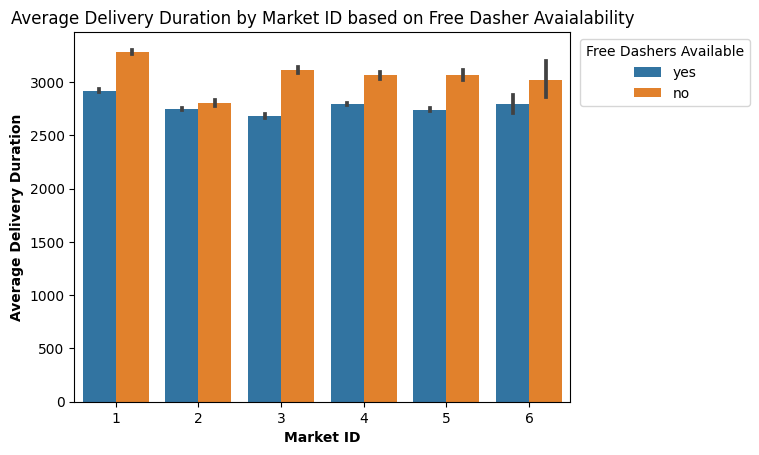

In [13]:
# now we look at how the availability of free dashers might affect delivery duration in each market
sns.barplot(data=multivariate_df, x='market_id', y='delivery_duration', hue='free_dashers_available')
plot_label(title="Average Delivery Duration by Market ID based on Free Dasher Avaialability", x_label="Market ID", y_label="Average Delivery Duration", legend=True, legend_title="Free Dashers Available", legend_loc=[1.02, 0.8]);

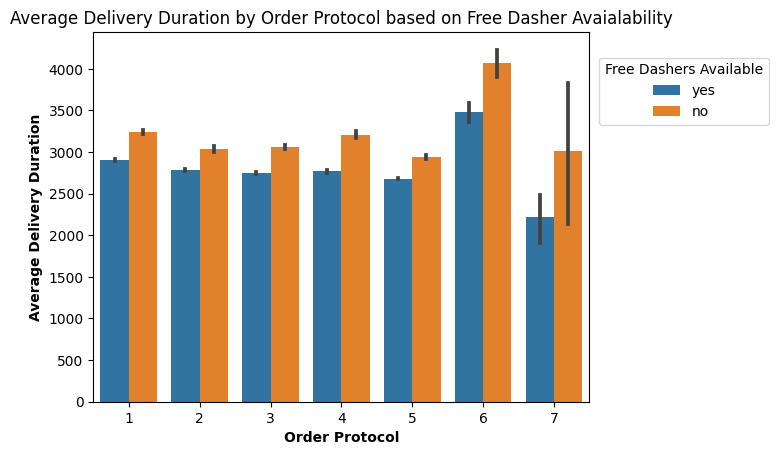

In [14]:
# now we look at how the availability of free dashers might affect delivery duration in each market
sns.barplot(data=multivariate_df, x='order_protocol', y='delivery_duration', hue='free_dashers_available')
plot_label(title="Average Delivery Duration by Order Protocol based on Free Dasher Avaialability", x_label="Order Protocol", y_label="Average Delivery Duration", legend=True, legend_title="Free Dashers Available", legend_loc=[1.02, 0.75]);

## Conclusion

Delivery duration is likely affected by:
- the estimated order creation to delivery duration
- the availability of free dashers within 10 miles of the corresponding store
- the proportion of onshift dashers within a 10 mile radius of the store who aren't working on another order
- the number of orders within 10 miles of the store being processed.

Markets 1 and 3 likely require the recruitment of more dashers to reduce the frequency of orders where not dashers are available within a 10 mile radius of the store to deliver the order. Similarly, protocol 6 orders would also require more dashers to reduce the frequency of orders without free dashers available.

Almost 20.5% of all records in the original dataset had values of total onshift dashers less than those of total busy dashers. More care should be taken when recording dasher count values to avoid the frequency of such errors. In this, case I simply swapped the values between these 2 columns where this error occurred.

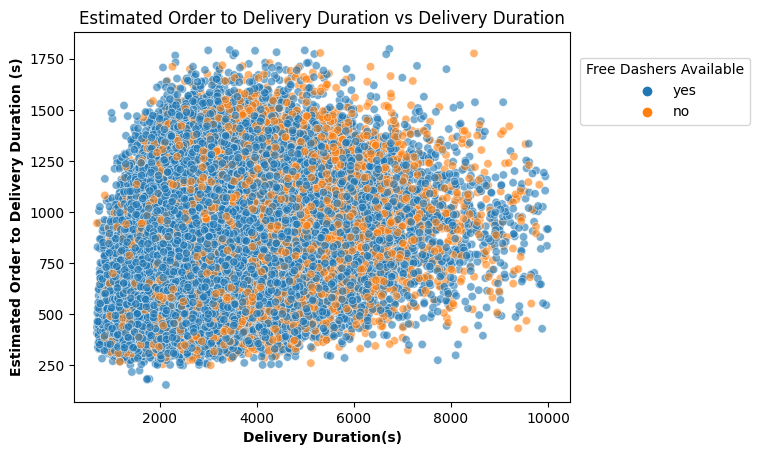

In [15]:
sns.scatterplot(data=multivariate_df, x='delivery_duration', y='estimated_order_to_delivery_duration', hue='free_dashers_available', alpha=0.6)
plot_label(title="Estimated Order to Delivery Duration vs Delivery Duration", x_label="Delivery Duration(s)", y_label="Estimated Order to Delivery Duration (s)", legend=True, legend_title="Free Dashers Available", legend_loc=[1.02, 0.75]);

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 